## Introduction: 
In this notebook we will be building a Multinomial Naive Bayes model or MNB for the task of text categorization. More specifically the we will be solving the stack_overflow question classification where questions of the well known coding platforme have been tagged as one of the followinf classes: C#, Java, JS, Python.

### 1. Load the dataset

In [ ]:
import os
import math
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import text_to_word_sequence
  

### 2. Corpus preprocessing 

In [ ]:
df_train=pd.read_csv('/content/train.csv',index_col=0)
df_train

,year,synopsis,genres
movie_id,,,
0,2005,Cruel But Necessary is the story of Betty Muns...,Drama
1,2012,"Yorkshire, 1974, the Maynard family moves into...",Drama Horror Thriller
2,2017,When a renowned architecture scholar falls sud...,Drama
3,1996,The story dealt with Lord Rama and his retalia...,Children Drama
4,2003,A Thai playboy cons a girl into bed and then l...,Comedy Drama Horror Thriller
...,...,...,...
37664,1954,A botanical expedition to the Himalayas captur...,Horror
37665,1962,The private life of Hitler revealed for the fi...,War
37666,2017,A nonfiction account of the Ferguson uprising ...,Documentary


In [ ]:
for i,sample in enumerate(df_train.iterrows()):
  genres=(sample[1][2]).split()
  if len(genres)>1:
    year=sample[1][0]
    synopsis=sample[1][1]
    df_train.iloc[i,2]=genres[0]
    for cpt in range(1,len(genres)):
      df_train=df_train.append({'year':year,'synopsis':synopsis,'genres':genres[cpt]},ignore_index=True)

In [ ]:
#Gathering and standardizing each category sequences
python=""
for text in os.listdir('./corpus/train/python'):
  text_content= open('./corpus/train/python/'+text)
  python+=" "+ text_content.read().lower()

javascript=""
for text in os.listdir('./corpus/train/javascript'):
  text_content= open('./corpus/train/javascript/'+text)
  javascript+= " "+ text_content.read().lower()

csharp=""
for text in os.listdir('./corpus/train/csharp'):
  text_content= open('./corpus/train/csharp/'+text)
  csharp+=" "+ text_content.read().lower()

java=""
for text in os.listdir('./corpus/train/java'):
  text_content= open('./corpus/train/java/'+text)
  java+= " "+ text_content.read().lower()


In [ ]:
#tokenizing the sequences
python= text_to_word_sequence(python)
java= text_to_word_sequence(java)
javascript= text_to_word_sequence(javascript)
csharp= text_to_word_sequence(csharp)

### Counts and frequencies

The model is based on word counts and follows maximum likelihood computation and naive bayes assumption. The predicted class $\hat C$ is deducted by the equation bellow:

  >>  $\hat C= argmax_{c \in C} [ log(P(c)]+ \sum_{w\in V} P(w/c)$




In [ ]:
#Count Nc the number of documents of category c
Nc={}
for category in os.listdir('./corpus/train'):
  Nc[category]=(len(os.listdir('./corpus/train/'+category)))
print(Nc)

{'python': 2000, 'javascript': 2000, 'csharp': 2000, 'java': 2000}


In [ ]:
#build frequency dict for each category where Nwc is the number of occurence of word w in sequence of category c
python_freq={}
for word in python:
  if word in python_freq.keys():
    python_freq[word]+=1
  else:
    python_freq[word]=1
python_freq={k: v for k, v in sorted(python_freq.items(), key=lambda item: item[1],reverse=True)}
java_freq={}
for word in java:
  if word in java_freq.keys():
    java_freq[word]+=1
  else:
    java_freq[word]=1
java_freq={k: v for k, v in sorted(java_freq.items(), key=lambda item: item[1],reverse=True)}

csharp_freq={}
for word in csharp:
  if word in csharp_freq.keys():
    csharp_freq[word]+=1
  else:
    csharp_freq[word]=1
csharp_freq={k: v for k, v in sorted(csharp_freq.items(), key=lambda item: item[1],reverse=True)}

javascript_freq={}
for word in javascript:
  if word in javascript_freq.keys():
    javascript_freq[word]+=1
  else:
    javascript_freq[word]=1
javascript_freq={k: v for k, v in sorted(javascript_freq.items(), key=lambda item: item[1],reverse=True)}


In [ ]:
#build vocabulary for all categories
vocab=[]
for word in zip(python_freq,java_freq,javascript_freq,csharp_freq):
  vocab.append(word)

### Learning MNB model

In [ ]:
#Probability of word w given category c P(w/c)
def p_w_c(word,category):
  if category=='python':
    if word in python_freq.keys():
      return (python_freq[word]+1)/(sum(python_freq.values())+len(vocab))
    else:
      return (1)/(sum(python_freq.values())+len(vocab))
 
  elif category=='java':
    if word in java_freq.keys():
      return (java_freq[word]+1)/(sum(java_freq.values())+len(vocab))
    else:
      return (1)/(sum(java_freq.values())+len(vocab))

  elif category=='javascript':
    if word in javascript_freq.keys():
      return (javascript_freq[word]+1)/(sum(javascript_freq.values())+len(vocab))
    else:
      return (1)/(sum(javascript_freq.values())+len(vocab))
  
  elif category=='csharp':
    if word in csharp_freq.keys():
      return (csharp_freq[word]+1)/(sum(csharp_freq.values())+len(vocab))
    else:
      return (1)/(sum(csharp_freq.values())+len(vocab))

#Probability of categorry c P(c)
def p_c(category):
  return Nc[category]/sum(Nc.values())

#Probability of document doc given c P(w1,w2,....,wn/c)
def p_d_c(doc,category):
  words=text_to_word_sequence(doc)
  proba_word=[]
  for word in words:
    proba_word.append(p_w_c(word,category))
  p_d_c= math.log(p_c(category))
  for proba in proba_word:
    p_d_c+= math.log(proba)
  return p_d_c

#Naive Bayes Classifier
def c_NB(doc):
  categories=['python','java','javascript','csharp']
  probas=[]
  for c in categories:
    prob=p_d_c(doc,c)
    probas.append(prob)
    #print(f" category={c} -> {prob}")

  return categories[np.argmax(probas)]

In [ ]:
p_w_c("function",'python')

0.0024614553893522666

In [ ]:
python_freq['function']

856

In [ ]:
doc="filtering a list in blank so i have two lists .one is an attorney object list and the other is a list with guid .i am first just filling the guid list with values and then looping through it and then matching it to the id field of attorney object to get the attorney's with the given id ...is there a nicer way than my try to achieve this. ..list&lt;attorney&gt; attorneys = msg.casedocument.attorneys;.list&lt;attorney&gt; casedefendantatt = new list&lt;attorney&gt;();.list&lt;guid&gt; attorneyid = new list&lt;guid&gt;();..foreach (var s in msg.casedocument.defendants).{.    attorneyid.addrange(s.attorneys);               ..}.foreach (var p in attorneyid).{.    var z = attorneys.findall(o =&gt; o.attorneyid == p);.    if (z != null).    {.        casedefendantatt.addrange(z);..    }..}"
c_NB(doc)

'csharp'

### Test and evaluation

In [ ]:
confusion_matrix=np.zeros((4,4))
idx={'python':0,'javascript':1,'csharp':2,'java':3}
for category in os.listdir("./corpus/test"):
  for doc in os.listdir('./corpus/test/'+category):
    sequence=open('./corpus/test/'+category+'/'+doc)
    sequence= sequence.read().lower()
    prediction= c_NB(sequence)
    confusion_matrix[idx[prediction],idx[category]]+=1    


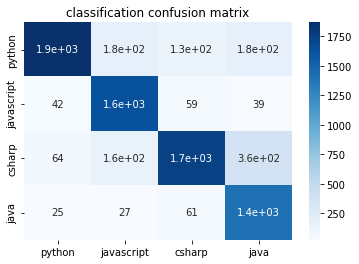

In [ ]:
ax=sns.heatmap(confusion_matrix,cmap='Blues',annot=confusion_matrix)
ax.set_title('classification confusion matrix')
ax.xaxis.set_ticklabels(idx.keys())
ax.yaxis.set_ticklabels(idx.keys())
plt.show()